We install and import the libraries needed

In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 

I import the data from excel into Pandas

In [3]:
data=pd.read_excel("../data/Data_BC_GlobalDelivery (1).xlsx")

In [4]:
data.head()

,journey_id,user_id,driver_id,icon,start_type,start_at,start_lat,start_lon,end_at,end_lat,...,price_distance,price_duration,distance,duration,cost,cost_distance,cost_duration,source,driver_score,rider_score
0,23a1406fc6a11d866e3c82f22eed4d4c,0e9af5bbf1edfe591b54ecdfd7e91e26,583949a89a9ee17d19e3ca4f137b6b4c,executive,asap,2010-11-16 16:44:52.000002,-12.139835,-77.023560,2010-11-16 17:29:56.999996,-12.055370,...,3626.0,195.0,11331.0,234.0,0.0,0.0,0.0,iPhone,5.0,5.0
1,dd2af4715d0dc16eded53afc0e243577,a553c46e3a22fb9c326aeb3d72b3334e,NaN,executive,asap,2010-06-01 00:34:37.999998,-12.138748,-76.995361,2010-06-01 00:37:38.999997,-12.124657,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
2,dd91e131888064bf7df3ce08f3d4b4ad,a553c46e3a22fb9c326aeb3d72b3334e,NaN,executive,asap,2010-05-31 05:01:24.000004,-12.124531,-77.027802,2010-05-31 05:04:33.999998,-12.138832,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
3,dd2af4715d0dc16eded53afc0e2466d0,a553c46e3a22fb9c326aeb3d72b3334e,NaN,executive,asap,2010-06-01 00:29:29.999999,-12.138851,-76.995300,2010-06-01 00:32:34.999999,-12.124588,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,iPhone,NaN,NaN
4,85b7eabcf5d84e42dc7629b7d27781af,56772d544fdfa589a020a1ff894a86f7,d665fb9f75ef5d9cd0fd89479380ba78,executive,reserved,2010-09-11 23:55:00.000002,-12.089954,-76.926270,2010-09-12 01:07:01.999998,-12.022232,...,7665.0,562.0,30270.0,715.0,6173.0,5756.0,417.0,iPhone,4.0,5.0


### Exploring and analyzing drivers data

In [5]:
drivers=data.driver_id.unique()

In [6]:
len(drivers)

169

I drop the records for which we dont have a driver_id as they wont be useful for the analysis

In [7]:
data=data[data.driver_id.notna()]

In [8]:
data.reset_index(inplace=True)

In [9]:
data=data.drop("index",axis=1)

In [10]:
data2=data[["driver_id","journey_id","price","cost","end_state","driver_score","rider_score"]]

In [11]:

driv_summary=data2.groupby(["driver_id","end_state"]).agg({"journey_id":"count","price":"sum","cost":"sum","driver_score":"mean","rider_score":"mean"})

In [12]:
driv_summary.reset_index(inplace=True)

In [13]:
driver_canceling=driv_summary[driv_summary.end_state=="driver cancel"]

There are 168 different riders, of which 65 have canceled their journeys ("driver cancel") at least once

At this point I have to decide from which amount of cancelations made by the drivers we can consider them as low quality drivers as if they only have a few number of cancelations it may be due to extraordinary causes. 

For this i can only focus on absolute numbers, but instead I will have to look at the % of journeys they have cancelled. (its not the same to cancel 8 out of 300 that 2 out of 15. Therefore we first need to check the % cancelation.

In [14]:
driver_canceling.set_index("driver_id",inplace=True)

In [15]:
driver_canceling["total_journeys"]=0

/var/folders/tr/7ry1klqj22sglvfj6nq3g5kw0000gn/T/ipykernel_60943/2160433506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_canceling["total_journeys"]=0


In [16]:
journeys=data.groupby("driver_id").count()

In [17]:
driver_canceling=driver_canceling.assign(total_journeys=journeys["journey_id"])

In [18]:
driver_canceling["percentage cancelled"]=(driver_canceling.journey_id/driver_canceling.total_journeys)*100

I am going to classify as low quality drivers those with a percentage of trips cancelled by them greater than 8%

In [19]:
low_quality_drivers=driver_canceling.index[driver_canceling["percentage cancelled"]>=8]

In [20]:
low_quality_drivers=list(low_quality_drivers)

In [21]:
medium_quality_drivers=driver_canceling.index[(driver_canceling["percentage cancelled"]>=4)&(driver_canceling["percentage cancelled"]<=8)]

In [22]:
medium_quality_drivers=list(medium_quality_drivers)

In [23]:
high_quality_drivers=driver_canceling.index[driver_canceling["percentage cancelled"]<4]

In [24]:
high_quality_drivers=list(high_quality_drivers)

#### Now Im going to focus on the rating of the drivers

In [25]:
ratings=data[["driver_id","rider_score","driver_score"]]

In [26]:
ratings=ratings.groupby("driver_id").mean()

We are going to set as:

low quality drivers those that have a rating below 3.5, 


medium quality those with rating above 3.5 and below 4.5 


high quality those with rating higher than or equal to 4.5

In [27]:
for i in range(len(ratings.index)):      

    if ratings.driver_score[i]<3.5:
        
        low_quality_drivers.append(ratings.index[i])       

In [28]:
for i in range(len(ratings.index)):      

    if ratings.driver_score[i]<4.5 and ratings.driver_score[i]>=3.5 and ratings.driver_score[i] not in low_quality_drivers:
        
        medium_quality_drivers.append(ratings.index[i])       

In [29]:
for i in range(len(ratings.index)):      

    if ratings.driver_score[i]>=4.5 and ratings.driver_score[i] not in medium_quality_drivers and ratings.driver_score[i] not in low_quality_drivers:
        
        high_quality_drivers.append(ratings.index[i])  

I eliminate duplicates in the lists of drivers

In [30]:
low_quality_drivers=set(low_quality_drivers)
medium_quality_drivers=set(medium_quality_drivers)
high_quality_drivers=set(high_quality_drivers)

In [31]:
for i in low_quality_drivers:
    
    if i in medium_quality_drivers:
        medium_quality_drivers.remove(i)       

In [32]:
for i in low_quality_drivers:
    
    if i in high_quality_drivers:
        high_quality_drivers.remove(i)      

In [33]:
for i in medium_quality_drivers:
    
    if i in high_quality_drivers:
        high_quality_drivers.remove(i)        

In [34]:
len(high_quality_drivers)

26

#### We check "failure" and "not found" trips

For these type of trips we see that not found ones are due to the app not finding a driver and failure might be due to a fail in the app. Therefore thse wont be relevant right now to classify riders

#### Number of trips

Now we are going to classify drivers according to the time they work for us and the amount of profit (price-cost) they report on average to the company and we will classify them in low_productibity_drivers, medium_productibity_drivers and high_productibity_drivers

-low_productibity_drivers below the 30th percentile

-medium_productibity_drivers below the 60th percentile and above the 30th 

-high_productibity_drivers above the 75th percentile

In [35]:
journeys.journey_id.quantile(0.30)

9.0

In [36]:
low_productivity_drivers=journeys.index[journeys.journey_id<journeys.journey_id.quantile(0.30)]

In [37]:
low_productivity_drivers=list(low_productivity_drivers)

In [38]:
journeys.journey_id.median()

25.0

In [39]:
journeys.journey_id.mean()

117.41666666666667

In [40]:
medium_productivity_drivers=journeys.index[(journeys.journey_id<journeys.journey_id.quantile(0.75)) & (journeys.journey_id>=journeys.journey_id.quantile(0.30))]

In [41]:
medium_productivity_drivers=list(medium_productivity_drivers)

In [42]:
journeys.journey_id.quantile(0.75)

89.5

In [43]:
high_productivity_drivers=journeys.index[journeys.journey_id>journeys.journey_id.quantile(0.75)]

In [44]:
high_productivity_drivers=list(high_productivity_drivers)

Now Im going to calculate the average duration per trip and the average profit they make per trip as well as the total amount

In [45]:
trips=data[["driver_id","price","cost","duration","journey_id"]]

In [46]:
trips=trips.groupby("driver_id").agg({"price":"sum","cost":"sum","duration":"sum","journey_id":"count"})

In [47]:
trips["profit"]=trips.price-trips.cost

In [48]:
trips["avg_profit"]=trips.profit/trips.journey_id

In [49]:
loose_money=trips[trips.profit<0]

In [50]:
len(loose_money)

14

We see there are drivers that eventhough might have a considerable amount of trips, are loosing money, therefore we will classify them as low_productivity_drivers

I will classify as medium those with an average profit below the 0.5 quantile and above 0 and as high those between the 50th and 100th quartiles

In [51]:
for i in loose_money.index:
    
    if i not in low_productivity_drivers:
        
        low_productivity_drivers.append(i)

In [52]:
trips["profit"].quantile(0.50)

13413.5

In [53]:
for i in range(len(trips.index)):
    
    if trips["profit"][i]<676.7516556291391  and trips.profit[i]>0:
                                                        
        
        medium_productivity_drivers.append(i)      

In [54]:
for i in range(len(trips.index)):
    
    if trips["profit"][i]>=trips["profit"].quantile(0.50):
                                                        
        
        high_productivity_drivers.append(i)
        

I eliminate duplicates from the productivity lists

In [55]:
low_productivity_drivers=set(low_productivity_drivers)
medium_productivity_drivers=set(medium_productivity_drivers)
high_productivity_drivers=set(high_productivity_drivers)

In [56]:
for i in low_productivity_drivers:
    
    if i in medium_productivity_drivers:
        medium_productivity_drivers.remove(i)       

In [57]:
for i in low_productivity_drivers:
    
    if i in high_productivity_drivers:
        high_productivity_drivers.remove(i)       

In [58]:
for i in medium_productivity_drivers:
    
    if i in high_productivity_drivers:
        high_productivity_drivers.remove(i)      

In [59]:
len(high_productivity_drivers)

117

## Exploring and analyzing clients data

#### Rating scores

In the same way as we used drivers scores to calsify them, im going to use the "rider_score" to classify clients. In this case we will use the same metrics:

low_quality_riders <3.5

3.5<=medium_quality_riders<4.5

4.5<=high_quality_riders


In [89]:
low_quality_riders=[]
medium_quality_riders=[]
high_quality_riders=[]

In [90]:
for i in range(len(ratings.index)):      

    if ratings.rider_score[i]<3.5:
        
        low_quality_riders.append(ratings.index[i])   

In [91]:
for i in range(len(ratings.index)):      

    if ratings.rider_score[i]<4.5 and ratings.rider_score[i]>=3.5 :#and ratings.rider_score[i] not in low_quality_riders:
        
        medium_quality_riders.append(ratings.index[i])    

In [92]:
for i in range(len(ratings.index)):      

    if ratings.rider_score[i]>=4.5: #and ratings.rider_score[i] not in medium_quality_riders and ratings.rider_score[i] not in low_quality_riders:
        
        high_quality_riders.append(ratings.index[i])  

#### Average and total profit and riders made by users

Now Im going to check the amount of rides each customer has done as well as the profits we made with each customer and the average profit their trips report to the company 

In [93]:
riders=data[["user_id","journey_id","end_state","duration","price","cost","distance"]]

In [94]:
riders=riders.groupby("user_id").agg({"journey_id":"count","end_state":"count","duration":"sum","cost":"sum","price":"sum","distance":"sum"})

In [95]:
riders.journey_id.max()

630

In [96]:
riders["profit"]=riders.price-riders.cost

In [97]:
riders["avg_profit"]=riders.profit/riders.journey_id

In [98]:
riders.profit.quantile(0.25)

938.0

In [99]:
for i in range(len(riders.index)):      

    if riders.profit[i]<riders.profit.quantile(0.25):
        
        low_quality_riders.append(riders.index[i])   

In [100]:
riders.profit.quantile(0.5)

3174.0

In [101]:
for i in range(len(riders.index)):      

    if riders.profit[i]<riders.profit.quantile(0.5):
        
        medium_quality_riders.append(riders.index[i])   

In [102]:
riders.profit.quantile(0.75)

11078.0

In [103]:
for i in range(len(riders.index)):      

    if riders.profit[i]>riders.profit.quantile(0.5):
        
        high_quality_riders.append(riders.index[i])   

In [104]:
riders.avg_profit.quantile(0.25)

519.3333333333334

In [105]:
riders.avg_profit.quantile(0.5)

1034.0

In [138]:
riders.avg_profit.mean()

561.5409199881333

In [106]:
riders.avg_profit.quantile(0.75)

1650.0

In [107]:
low_quality_riders=set(low_quality_riders)
medium_quality_riders=set(medium_quality_riders)
high_quality_riders=set(high_quality_riders)

In [109]:
for i in low_quality_riders:
    
    if i in medium_quality_riders:
        medium_quality_riders.remove(i)  

In [110]:
for i in low_quality_riders:
    
    if i in high_quality_riders:
        high_quality_riders.remove(i)   

In [111]:
for i in medium_quality_riders:
    
    if i in high_quality_riders:
        high_quality_riders.remove(i) 

In [136]:
len(low_quality_riders)

344

### Correlations between variables

I check correlation between variables which i might have not spoted

In [143]:
import seaborn as sns

In [145]:
import numpy as np

In [139]:
corr=data.corr(method='pearson')

In [147]:
corr

,start_lat,start_lon,end_lat,end_lon,driver_start_lat,driver_start_lon,price,price_distance,price_duration,distance,duration,cost,cost_distance,cost_duration,driver_score,rider_score
start_lat,1.000000,-0.394971,0.000759,0.013101,0.018066,0.009889,0.045909,0.005320,0.037522,0.004159,0.032566,0.006661,0.003967,0.035003,0.017973,-0.002991
start_lon,-0.394971,1.000000,-0.004213,0.001531,0.049369,0.053464,-0.007620,0.001083,-0.031350,0.002198,-0.027392,0.002089,-0.003639,-0.040477,-0.016395,0.014453
end_lat,0.000759,-0.004213,1.000000,0.289164,-0.003140,-0.003350,0.017930,-0.000424,-0.002870,-0.000819,-0.003020,-0.001967,-0.000415,-0.004565,0.007794,0.008932
end_lon,0.013101,0.001531,0.289164,1.000000,0.011355,0.011216,0.012144,-0.000320,0.003181,-0.000598,0.002670,-0.000178,-0.000412,0.000466,-0.007417,-0.014445
driver_start_lat,0.018066,0.049369,-0.003140,0.011355,1.000000,0.994215,-0.035689,0.086845,-0.021131,0.104542,-0.016358,-0.007663,0.058224,-0.033749,0.033201,0.007910
driver_start_lon,0.009889,0.053464,-0.003350,0.011216,0.994215,1.000000,-0.033894,0.087270,-0.020871,0.105011,-0.016112,-0.007441,0.058583,-0.033448,0.032683,0.008602
price,0.045909,-0.007620,0.017930,0.012144,-0.035689,-0.033894,1.000000,0.032534,0.605348,0.022213,0.601898,0.121940,0.036856,0.582016,-0.037278,-0.005659
price_distance,0.005320,0.001083,-0.000424,-0.000320,0.086845,0.087270,0.032534,1.000000,0.006747,0.971383,0.007069,0.005073,0.877969,0.007501,0.006549,0.007800
price_duration,0.037522,-0.031350,-0.002870,0.003181,-0.021131,-0.020871,0.605348,0.006747,1.000000,0.002522,0.997152,0.076299,0.008930,0.947594,-0.012751,-0.000510
distance,0.004159,0.002198,-0.000819,-0.000598,0.104542,0.105011,0.022213,0.971383,0.002522,1.000000,0.004799,0.004594,0.794745,0.002926,0.006556,0.008456


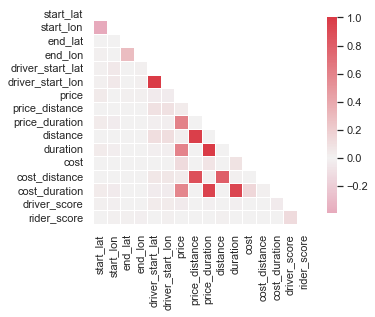

In [153]:
sns.set(style='white')   # estilo blanco


mascara=np.triu(np.ones_like(corr, dtype=bool))    # genera una mascara para la triangular superior


cmap=sns.diverging_palette(0, 10, as_cmap=True)    # paleta de colores

sns.heatmap(corr,
            mask=mascara,
            cmap=cmap,
            vmax=1,
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink':0.9}
           );

### Dates exploration

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19726 entries, 0 to 19725
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   journey_id        19726 non-null  object        
 1   user_id           19726 non-null  object        
 2   driver_id         19726 non-null  object        
 3   icon              19726 non-null  object        
 4   start_type        19726 non-null  object        
 5   start_at          19726 non-null  datetime64[ns]
 6   start_lat         19726 non-null  float64       
 7   start_lon         19726 non-null  float64       
 8   end_at            19718 non-null  datetime64[ns]
 9   end_lat           19726 non-null  float64       
 10  end_lon           19726 non-null  float64       
 11  end_state         19726 non-null  object        
 12  driver_start_lat  19576 non-null  float64       
 13  driver_start_lon  19576 non-null  float64       
 14  arrived_at        1771

In [157]:
times=data[["driver_id","start_at"]]

In [163]:
times["year"] = pd.DatetimeIndex(times['start_at']).year
times["month"] = pd.DatetimeIndex(times['start_at']).month
times["day"] = pd.DatetimeIndex(times['start_at']).day

/var/folders/tr/7ry1klqj22sglvfj6nq3g5kw0000gn/T/ipykernel_60943/138496336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times["year"] = pd.DatetimeIndex(times['start_at']).year
/var/folders/tr/7ry1klqj22sglvfj6nq3g5kw0000gn/T/ipykernel_60943/138496336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times["month"] = pd.DatetimeIndex(times['start_at']).month
/var/folders/tr/7ry1klqj22sglvfj6nq3g5kw0000gn/T/ipykernel_60943/138496336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [164]:
times

,driver_id,start_at,year,month,day
0,583949a89a9ee17d19e3ca4f137b6b4c,2010-11-16 16:44:52.000002,2010,11,16
1,d665fb9f75ef5d9cd0fd89479380ba78,2010-09-11 23:55:00.000002,2010,9,11
2,baacf396f773709519bbde35a5eab861,2010-08-10 13:00:00.000003,2010,8,10
3,e1332f68e81526e498e4d845233a6d7d,2010-08-08 12:09:59.999996,2010,8,8
4,d665fb9f75ef5d9cd0fd89479380ba78,2010-05-16 03:58:58.999996,2010,5,16
...,...,...,...,...,...
19721,d665fb9f75ef5d9cd0fd89479380ba78,2010-07-31 13:14:59.999997,2010,7,31
19722,17c21284245ff240c7212732991c2373,2010-10-02 05:26:38.000000,2010,10,2
19723,4851ee4c867c9b49b909c1adb76c31e9,2010-09-21 09:56:40.000004,2010,9,21
19724,56f59b58bcbbd1cdabc3652e713134c2,2010-04-29 04:30:00.000000,2010,4,29


In [174]:
date_summary=times.groupby(["driver_id"]).agg({"year":"count","day":"count","start_at":"count","month":"sum"})

In [179]:
date_summary=times.groupby("driver_id")["month"].nunique()

In [217]:
high_length=list(date_summary[date_summary>=10].index)

In [218]:
medium_length=list(date_summary[(date_summary>=6)&(date_summary<10)].index)

In [219]:
low_length=list(date_summary[date_summary<6].index)

In [212]:
len(high_length)

119

In [223]:
a=0

for i in medium_length:
    
    if i in high_productivity_drivers:
        
        a+=1
print(a)

14


from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
